In [1]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import csv

In [2]:
Ad      = 4.4e16
Ed      = 140.06e3
Ap      = 1.7e11/60
Ep      = 16.9e3/0.239
deltaHp = -82.2e3
UA      = 33.3083 #%18.8445;
Qc      = 650
Qs      = 12.41e-2
V       = 0.5
Tc      = 27
Tamb    = 27
Cpc     = 4.184
R       = 8.3145
alpha   = 1.212827
beta    = 0.000267
epsilon = 0.5
theta   = 1.25
m1      = 450
cp1     = 4.184
mjCpj   = (18*4.184)+(240*0.49)
cp2     = 187
cp3     = 110.58 #%J/molK
cp4     = 84.95
m5      = 220
cp5     = 0.49
m6      = 7900
cp6     = 0.49
M0      = 0.7034
I0      = 4.5e-3

# Define Batch Reactor model
def br(x,t,u,Ad):
    # Inputs:
    # Coolant flow rate
    F = u*16.667

    # States (4):
    # Initiator
    Ii  = x[0]
    # Monomer
    M  = x[1]
    # Reactor temperature
    Tr = x[2]
    # Jacket temperature
    Tj = x[3]

    Ri    = Ad*Ii*(np.exp(-Ed/(R*(Tr+273.15))))
    Rp    = Ap*(Ii**epsilon)*(M**(theta)*(np.exp(-Ep/(R*(Tr+273.15)))))
    mrCpr = m1*cp1+ Ii*cp2*V + M*cp3*V +(M0-M)*cp4*V+ m5*cp5 + m6*cp6
    Qpr   = alpha*(Tr-Tc)**beta

    # Computing the rate of change of I, M, Tr, Tj using Differential Equations
    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp*V*(-deltaHp)-UA*(Tr-Tj)+Qc+Qs-Qpr)/mrCpr
    dy4_dt = (UA*(Tr-Tj)-F*Cpc*(Tj-Tc))/mjCpj

    # Return xdot:
    xdot = np.zeros(4)
    xdot[0] = dy1_dt
    xdot[1] = dy2_dt
    xdot[2] = dy3_dt
    xdot[3] = dy4_dt

    return xdot



In [3]:

class BR3(gym.Env):

    def __init__(self):
        self.action_space = spaces.Box(low=0.25, high=0.75, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

        self.t = np.linspace(0, 7200, 7201)
        self.i = 0

        Tr_ref = pd.read_csv('Trajectory2.csv')
        self.a1 = Tr_ref.values.tolist()
        self.sp = self.a1[self.i][0]

        # Initial conditions
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.state = self.Tr, self.sp

        self.y0 = np.empty(4)
        self.y0[0] = self.I
        self.y0[1] = self.M
        self.y0[2] = self.Tr
        self.y0[3] = self.Tj

        self.time_step = 7200

    def step(self, action):
        action = action[0]
        u = action

        ts = [self.t[self.i], self.t[self.i+1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16))
        x = np.round(y, decimals=4)

        self.I = x[-1][0]
        self.M = x[-1][1]
        self.Tr = x[-1][2]
        self.Tj = x[-1][3]

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        # Data saving with overwrite logic
        data = [self.sp, self.Tr, self.Tj, action]
        mode = 'w' if self.i == 0 else 'a'
        with open('data.csv', mode, newline='') as file:
            writer = csv.writer(file)
            if self.i == 0:
                writer.writerow(['Setpoint', 'Reactor Temperature', 'Jacket Temperature', 'Action'])
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i][0]

        difference = self.sp - self.Tr
        error = abs(difference)

        # Reward logic
        if error <= 0.5:
            self.reward = +100
        elif error <= 1:
            self.reward = +50
        elif error <= 3:
            self.reward = +25
        elif error <= 4:
            self.reward = +10
        else:
            self.reward = -100

        done = self.i >= self.time_step
        info = {}

        self.state = self.Tr, self.sp
        return self.state, self.reward, done, info

    def reset(self, **kwargs):
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.i = 0

        self.sp = self.a1[self.i][0]
        self.state = (self.Tr, self.sp)

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])
        self.prev_action = 0.5  # Initialize previous action

        return self.state, {}

In [4]:
# GPU/CPU setup
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


  2%|▏         | 1/50 [04:33<3:43:30, 273.68s/it]

Episode 0 | Train: -69130.0 | Eval: 337295.0 | Noise: 0.1980


100%|██████████| 50/50 [2:54:46<00:00, 209.73s/it]  


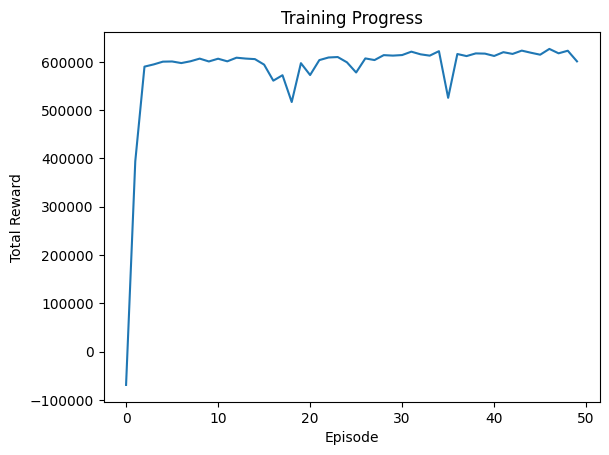

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from collections import namedtuple
from collections import deque  # You'll need this too for the ReplayBuffer class
import torch.nn.functional as F  # This is also needed for F.mse_loss
from torch.utils.tensorboard import SummaryWriter


# --- Same imports, device, etc. as you wrote ---

from __main__ import BR3  # Or import your BR3 class properly
class Actor(nn.Module):
    def __init__(self, obs_dim=2, action_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh()
        )
        
    def forward(self, state):
        action = self.net(state) * 0.25 + 0.5  # Scale to [0.25, 0.75]
        return action

class Critic(nn.Module):
    def __init__(self, obs_dim=2, action_dim=1):  # Change obs_dim to 2
        super().__init__()
        self.state_net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
        )
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
        )
        self.q_net = nn.Sequential(
            nn.Linear(256 + 128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        
    def forward(self, state, action):
        s_feat = self.state_net(state)
        a_feat = self.action_net(action)
        return self.q_net(torch.cat([s_feat, a_feat], dim=-1))

# ========================
# IMPROVED REPLAY BUFFER
# ========================
Transition = namedtuple('Transition', 
                       ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=1e6):
        self.buffer = deque(maxlen=int(capacity))
        
    def push(self, *args):
        self.buffer.append(Transition(*args))
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (torch.FloatTensor(np.array(states)),
                torch.FloatTensor(np.array(actions)),
                torch.FloatTensor(np.array(rewards)).unsqueeze(-1),
                torch.FloatTensor(np.array(next_states)),
                torch.FloatTensor(np.array(dones)).unsqueeze(-1))
    
    def __len__(self):
        return len(self.buffer)

# ========================
# MODIFIED TRAINING LOOP
# ========================
class DDPG:
    def __init__(self, params=None):
        # Initialize parameters with defaults if not provided
        if params is None:
            self.params = {
                'episodes': 20,
                'batch_size': 1024,
                'buffer_capacity': 1e5,
                'gamma': 0.95,
                'tau': 0.05,
                'noise_std': 0.2,
                'noise_decay': 0.99,
                'grad_clip': 0.5,
                'actor_lr': 5e-4,
                'critic_lr': 5e-3
            }
        else:
            self.params = params
            
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        try:
            # Initialize networks
            self.actor = Actor(obs_dim=2, action_dim=1).to(self.device)
            self.critic = Critic(obs_dim=2, action_dim=1).to(self.device)
            self.target_actor = Actor(obs_dim=2, action_dim=1).to(self.device).eval()
            self.target_critic = Critic(obs_dim=2, action_dim=1).to(self.device).eval()
            
            # Initialize optimizers with parameters
            self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.params['actor_lr'])
            self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.params['critic_lr'])
            
        except Exception as e:
            print(f"Initialization error: {e}")
            raise
        
        # Set hyperparameters
        self.gamma = self.params['gamma']
        self.tau = self.params['tau']
        self.batch_size = self.params['batch_size']
        self.noise_std = self.params['noise_std']
        self.noise_decay = self.params['noise_decay']
        self.grad_clip = self.params['grad_clip']
        self.episodes = self.params['episodes']
        
        # Initialize replay buffer
        self.buffer = ReplayBuffer(self.params['buffer_capacity'])
        
        # TensorBoard writer
        self.writer = SummaryWriter(log_dir="runs/ddpg_training")

    # Rest of the class remains the same...


        
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Critic loss
        with torch.no_grad():
            target_actions = self.target_actor(next_states)
            target_q = self.target_critic(next_states, target_actions)
            target_q = rewards + (1 - dones) * self.gamma * target_q
            
        current_q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)
        
        # Critic optimization
        self.critic_optim.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip)  # NEW
        self.critic_optim.step()
        
        # Actor loss
        actor_actions = self.actor(states)
        actor_loss = -self.critic(states, actor_actions).mean()
        
        # Actor optimization
        self.actor_optim.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_clip)  # NEW
        self.actor_optim.step()
        
        # Soft updates
        with torch.no_grad():
            for t_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
                t_param.data.copy_(self.tau * param.data + (1 - self.tau) * t_param.data)
            for t_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
                t_param.data.copy_(self.tau * param.data + (1 - self.tau) * t_param.data)
                    
    
        
    def train(self, episodes=50):
        env = BR3()
        rewards = []
        best_reward = -np.inf
        
        for episode in tqdm(range(episodes)):
            state_info = env.reset()
            state = state_info[0]  # Extract just the state from the tuple
            episode_reward = 0
            done = False
            
            while not done:
                # Decaying exploration noise
                with torch.no_grad():
                    action = self.actor(torch.FloatTensor(state).to(self.device)).cpu().numpy()
                noise = np.random.normal(0, self.noise_std, size=action.shape)
                action = np.clip(action + noise, 0.25, 0.75)
                
                # Environment step
                next_state, reward, done, _ = env.step(action)
                self.buffer.push(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                
                # Update networks
                self.update()
                
            # Decay noise
            self.noise_std *= self.noise_decay
            rewards.append(episode_reward)
            
            # Log to TensorBoard
            self.writer.add_scalar('Training/Episode_Reward', episode_reward, episode)
            self.writer.add_scalar('Training/Noise_STD', self.noise_std, episode)
            
            # Save best model
            if episode_reward > best_reward:
                best_reward = episode_reward
                torch.save(self.actor.state_dict(), "best_actor.pth")
                
            # Evaluation every 100 episodes
            if episode % 100 == 0:
                eval_reward = self.evaluate()
                self.writer.add_scalar('Evaluation/Reward', eval_reward, episode)
                print(f"Episode {episode} | Train: {episode_reward:.1f} | Eval: {eval_reward:.1f} | Noise: {self.noise_std:.4f}")
        
        self.writer.close()
        return rewards


    
    def evaluate(self, n_episodes=3):
        total_reward = 0
        env = BR3()
    
        for _ in range(n_episodes):
            state_info = env.reset()
            state = state_info[0]  # Extract just the state from the tuple
            done = False
            episode_reward = 0
            
            with torch.no_grad():
                while not done:
                    action = self.actor(torch.FloatTensor(state).to(self.device)).cpu().numpy()
                    next_state_info, reward, done, _ = env.step(action)
                    state = next_state_info  # No need to unpack here as step() returns just the state
                    episode_reward += reward
                    
            total_reward += episode_reward
        
        return total_reward / n_episodes

# ========================
# EXECUTION
# ========================
if __name__ == "__main__":
    ddpg = DDPG()
    rewards = ddpg.train()
    
    # Plot results
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.savefig("training_progress.png")


In [6]:
def visualize_agent(model_path, episodes=5):
    env = BR3()
    actor = Actor(obs_dim=2, action_dim=1)
    actor.load_state_dict(torch.load(model_path))
    
    for episode in range(episodes):
        state_info = env.reset()
        state = state_info[0]
        done = False
        episode_reward = 0
        states = []
        actions = []
        
        while not done:
            with torch.no_grad():
                action = actor(torch.FloatTensor(state)).cpu().numpy()
            next_state, reward, done, _ = env.step(action)
            
            states.append(state)
            actions.append(action)
            state = next_state
            episode_reward += reward
        
        # Plot trajectory
        states = np.array(states)
        actions = np.array(actions)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(states[:, 0], label='Temperature')
        plt.plot([states[i, 1] for i in range(len(states))], 'r--', label='Setpoint')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(actions, label='Actions')
        plt.legend()
        
        plt.suptitle(f"Episode {episode+1}, Reward: {episode_reward:.2f}")
        plt.tight_layout()
        plt.savefig(f"agent_behavior_{episode+1}.png")
        plt.close()
        
        print(f"Episode {episode+1} reward: {episode_reward:.2f}")

# Use the best saved model
visualize_agent("best_actor.pth")


C:\Users\arnav\AppData\Local\Temp\ipykernel_24056\3774371626.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load(model_path))


Episode 1 reward: 649645.00
Episode 2 reward: 649645.00
Episode 3 reward: 649645.00
Episode 4 reward: 649645.00
Episode 5 reward: 649645.00


In [7]:
# Export to TorchScript for production
actor = Actor(obs_dim=2, action_dim=1)
actor.load_state_dict(torch.load("best_actor.pth"))
actor.eval()
scripted_model = torch.jit.script(actor)
scripted_model.save("actor_production.pt")


C:\Users\arnav\AppData\Local\Temp\ipykernel_24056\1136534200.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("best_actor.pth"))


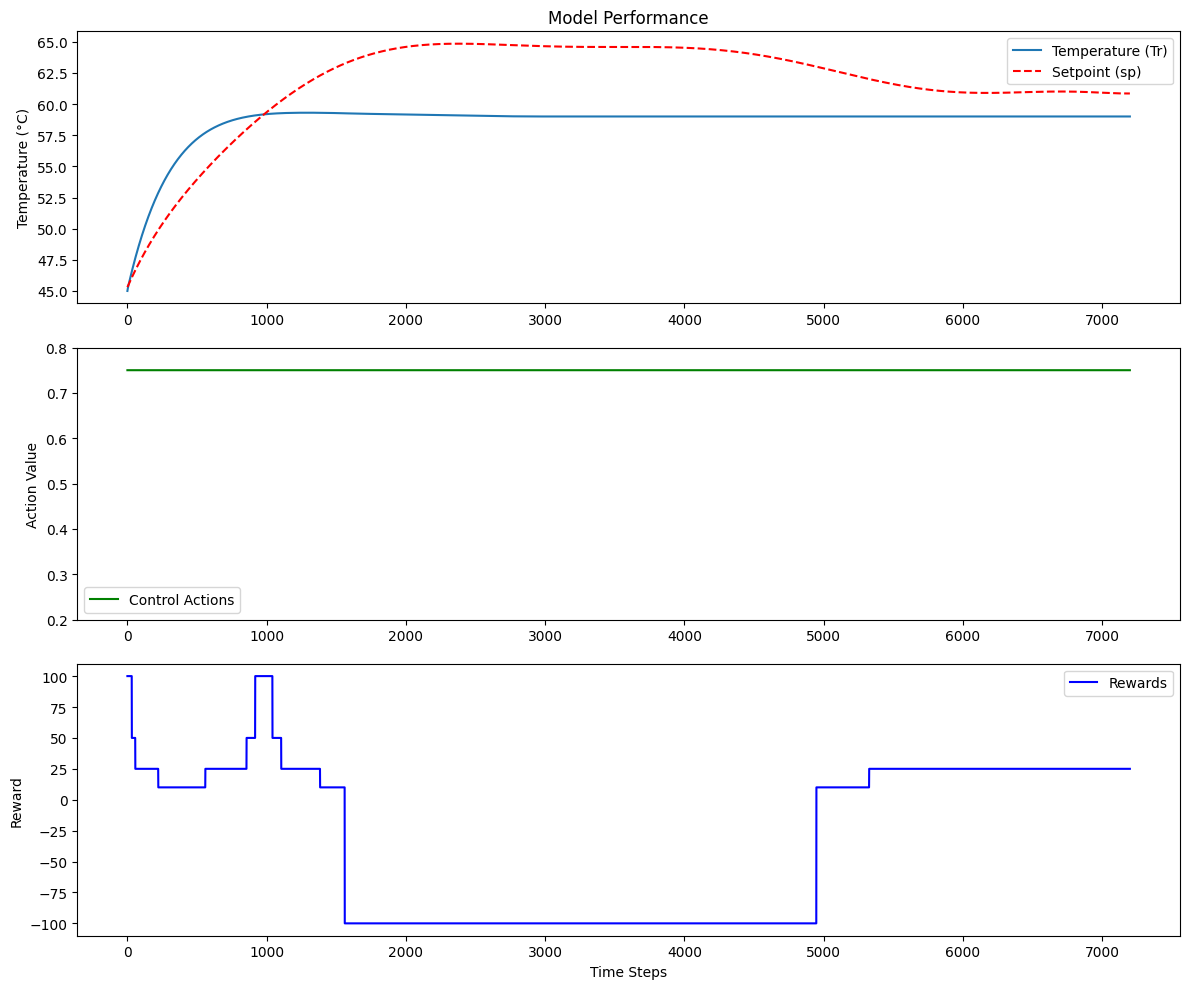

Performance Metrics:
Mean Reward: -33.52
Mean Tracking Error: 3.71°C


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F



# Actor Network
class Actor(nn.Module):
    def __init__(self, obs_dim=2, action_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh()
        )
        
    def forward(self, state):
        action = self.net(state) * 0.25 + 0.5  # Scale to [0.25, 0.75]
        return action

def visualize_model_performance(model_path="best_actor1.pth" ):
    # Load the trained actor model
    actor = Actor(obs_dim=2, action_dim=1)
    actor.load_state_dict(torch.load(model_path, weights_only=True))
    actor.eval()
    
    # Create environment with the specific trajectory file
    env = BR3()  # Use the default constructor
    
    # Run a single episode
    state_info = env.reset()
    state = state_info[0]
    done = False
    
    # Lists to store data for plotting
    temperatures = []
    setpoints = []
    actions = []
    rewards = []
    
    # Run the episode
    with torch.no_grad():
        while not done:
            # Get action from the model
            action = actor(torch.FloatTensor(state)).cpu().numpy()
            
            # Take step in environment
            next_state, reward, done, _ = env.step(action)
            
            # Store data for plotting
            temperatures.append(state[0])  # Temperature (Tr)
            setpoints.append(state[1])     # Setpoint (sp)
            actions.append(action[0])      # Control action
            rewards.append(reward)
            
            # Update state
            state = next_state
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Plot temperature vs setpoint
    plt.subplot(3, 1, 1)
    plt.plot(temperatures, label='Temperature (Tr)')
    plt.plot(setpoints, 'r--', label='Setpoint (sp)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.title('Model Performance')
    
    # Plot control actions
    plt.subplot(3, 1, 2)
    plt.plot(actions, 'g-', label='Control Actions')
    plt.ylabel('Action Value')
    plt.ylim(0.2, 0.8)
    plt.legend()
    
    # Plot rewards
    plt.subplot(3, 1, 3)
    plt.plot(rewards, 'b-', label='Rewards')
    plt.xlabel('Time Steps')
    plt.ylabel('Reward')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('model_performance.png')
    plt.show()
    
    # Calculate performance metrics
    mean_reward = np.mean(rewards)
    tracking_error = np.mean(np.abs(np.array(temperatures) - np.array(setpoints)))
    
    print(f"Performance Metrics:")
    print(f"Mean Reward: {mean_reward:.2f}")
    print(f"Mean Tracking Error: {tracking_error:.2f}°C")
    
    return temperatures, setpoints, actions, rewards

# Call the function to visualize performance
temps, setpoints, actions, rewards = visualize_model_performance("best_actor1.pth")



import torch
import torch.nn as nn

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dummy model (increase layer sizes if needed)
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(2, 512)  # Increased layer size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, s):
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x)) * 0.25 + 0.5
        return x

# Initialize model and move to GPU
model = TestModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Get total VRAM
total_vram = torch.cuda.get_device_properties(device).total_memory
max_vram_usage = total_vram * 0.9  # 90% of total VRAM

# Start testing batch sizes
batch_size = 256
max_batch_size = batch_size
while True:
    try:
        # Allocate a batch of input tensors
        dummy_input = torch.randn(batch_size, 2).to(device)
        dummy_target = torch.randn(batch_size, 1).to(device)

        # Forward pass
        output = model(dummy_input)
        loss = criterion(output, dummy_target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Check VRAM usage
        used_vram = torch.cuda.memory_allocated(device)
        print(f"Batch Size: {batch_size}, VRAM Used: {used_vram / (1024**2):.2f} MB")

        # If memory usage is safe, increase batch size
        if used_vram < max_vram_usage:
            max_batch_size = batch_size
            batch_size *= 2  # Double the batch size
        else:
            break  # Stop when we exceed safe VRAM usage

    except RuntimeError as e:
        print(f"Out of memory error at batch size {batch_size}: {e}")
        break

print(f"🚀 Maximum stable batch size: {max_batch_size}")
